<a href="https://colab.research.google.com/github/vixbi/machinelearning/blob/main/HW5_Shumakova_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка

In [1]:
!pip uninstall numpy -y
!pip install numpy==1.24.4 gensim

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
oldest-supported-numpy 2023.12.21 requires numpy==1.23.2; python_version == "3.11", but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25

In [38]:
# импорт необходимых библиотек
import pandas as pd

import sklearn.cluster as cluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ast
from tqdm import tqdm
import re
from collections import Counter
from itertools import chain
from IPython.display import Image, display

In [5]:
# необходимые файлы для работы с nltk
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("universal_tagset")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# чтобы было проще скачивать
def link_download(sharing_url, sep='\t', usecols=None, header=None):
    download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]
    dataframe = pd.read_csv(download_url, sep=sep, usecols=usecols, header=header)
    return dataframe

stckover_df = link_download("https://drive.google.com/file/d/1zLs02TTxbt1Htk1RdIJM5AaBacs6Y39K/view?usp=sharing",
                           sep=None, header='infer')
stckover_df.head(10)

<ipython-input-6-30a86395b97c>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  dataframe = pd.read_csv(download_url, sep=sep, usecols=usecols, header=header)


,Title,URL,Question,Categories
0,your browser version is not supported using sy...,https://stackoverflow.com/questions/76981459/y...,I'm trying to automate some features and I nee...,"['php', 'symfony', 'web-scraping']"
1,how to get button text value in java,https://stackoverflow.com/questions/76981456/h...,I want to get button text value to do the on c...,"['java', 'button']"
2,How to make sure communication is stable when ...,https://stackoverflow.com/questions/76981455/h...,This is my Node codeasync function runClient()...,"['javascript', 'node.js', 'go', 'zeromq']"
3,Cubical Agda Inclusion Order,https://stackoverflow.com/questions/76981453/c...,I'm almost finished defining an Inclusion Orde...,['agda']
4,How to convert depth map to image(.png) format...,https://stackoverflow.com/questions/76981450/h...,I am using a depth camera which captures a 500...,"['3d', 'computer-vision', 'point-clouds', 'vis..."
5,Spring Security for Mobile Application with 3r...,https://stackoverflow.com/questions/76981449/s...,I want to allow SSO (single sign-on) via Googl...,"['java', 'spring', 'spring-security', 'oauth-2..."
6,"{C#, UNITY} Currently working on a flight scri...",https://stackoverflow.com/questions/76981448/c...,[EDIT ONE: THE FLIGHT CODE IS COMMENTED BECAUS...,['c#']
7,Overlay a transparent button over each radio o...,https://stackoverflow.com/questions/76981447/o...,I need to overlay a transparent button over ea...,"['javascript', 'html', 'css']"
8,Vue list scrolling will affect external scroll...,https://stackoverflow.com/questions/76981446/v...,"By setting the height, the effect of scrolling...","['html', 'vue.js']"
9,How to list all resource to secret mappings?,https://stackoverflow.com/questions/76981442/h...,I am looking for a kubectl command that will l...,"['kubernetes', 'kubectl', 'kubernetes-secrets']"


In [7]:
# проверка на пропущенные значения
stckover_df.isna().any()

,0
Title,False
URL,False
Question,False
Categories,False


# Тексты без предобработки

## CountVectorizer: K-means

In [8]:
# поскольку у меня крашится память при попытке векторизовать текст, давайте
# я немного посмотрю на частотность отдельных токенов, используя токенизацию
# через регулярку r"(?u)\b\w\w+\b" (она указана у них в документации как дефолтная
# для параметра token_pattern)

natural_texts = [text.lower() for text in list(stckover_df.Question)]
tokens = [re.findall(r"(?u)\b\w\w+\b", text) for text in natural_texts]
# у меня там получился список списков, зафлаттеним это
tokens = list(chain.from_iterable(tokens))

In [11]:
token_freq = Counter(tokens)
len(token_freq)

249841

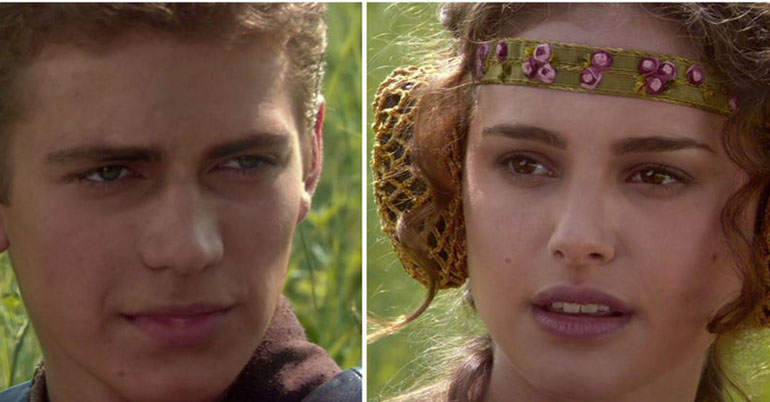

In [9]:
# ну, мы же не хотим векторы в 249841мерном пространстве, да?
display(Image("https://memepedia.ru/wp-content/uploads/2021/06/mem-k-luchshemu-verno.jpg"))

In [12]:
# попробуем взять на борт не всех
for i in range(11):
    print(f'Если оставить слова с частотой не меньше {i}, то останется столько уникальных слов: ',
          len([word for word, freq in token_freq.items() if token_freq[word] >= i]))

Если оставить слова с частотой не меньше 0, то останется столько уникальных слов:  249841
Если оставить слова с частотой не меньше 1, то останется столько уникальных слов:  249841
Если оставить слова с частотой не меньше 2, то останется столько уникальных слов:  122855
Если оставить слова с частотой не меньше 3, то останется столько уникальных слов:  77256
Если оставить слова с частотой не меньше 4, то останется столько уникальных слов:  57603
Если оставить слова с частотой не меньше 5, то останется столько уникальных слов:  44358
Если оставить слова с частотой не меньше 6, то останется столько уникальных слов:  37195
Если оставить слова с частотой не меньше 7, то останется столько уникальных слов:  31290
Если оставить слова с частотой не меньше 8, то останется столько уникальных слов:  27597
Если оставить слова с частотой не меньше 9, то останется столько уникальных слов:  24465
Если оставить слова с частотой не меньше 10, то останется столько уникальных слов:  22177


In [13]:
# давайте заберем в лучший мир слова, которые встретились хотя бы 8 раз
voc = {word: idx for idx, word in enumerate({word for word, freq in token_freq.items() if freq >= 8})}
count_vec = CountVectorizer(vocabulary=voc)
embeddings = count_vec.fit_transform(stckover_df.Question)
embeddings.shape

(22123, 27597)

### Функции для дальнейшей работы

Я пропишу все это дело уже после того, как сделала один раз кластеризацию. Чтобы не повторять лишний раз код, обернем его в функции

In [14]:
def get_pca_results(embeddings, n_dim):
    decompose = PCA(n_dim)
    pca_res = decompose.fit_transform(embeddings)
    return pca_res


def eval_clusters(pca_res, n_clusters=20):
    inertia, silhouette = [], {}
    for i in tqdm(range(2,n_clusters)):

        kmeans = cluster.KMeans(n_clusters=i,
                                init='k-means++',
                                n_init=15,
                                max_iter=500,
                                random_state=17)


        kmeans.fit(pca_res)
        inertia.append(kmeans.inertia_)
        silhouette[i] = silhouette_score(pca_res,
                                         kmeans.labels_,
                                         metric='euclidean')

    return inertia, silhouette


def plot_metrics(inertia, silhouette):
    sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

    plt.subplot(1, 2, 1)

    plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')

    plt.xlabel('Число кластеров')
    plt.title('K-means Inertia',fontweight='bold')
    plt.grid(True)

    plt.xticks(range(2, len(inertia)+2), fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(1, 2, 2)

    plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
    plt.xticks(range(len(silhouette)), list(silhouette.keys()))
    plt.grid(True)
    plt.title('Silhouette Score',fontweight='bold')
    plt.xlabel('Число кластеров')

    plt.show()


def get_nearest_texts(model, pca_res, texts=stckover_df.Question, display=True, ret=False):
    centroids = model.cluster_centers_
    clusters = model.labels_
    texts = list(stckover_df.Question)

    nearest_texts = {}

    for cluster_id in range(model.n_clusters):

        cluster_indices = [i for i, label in enumerate(clusters) if label == cluster_id]

        distances = euclidean_distances(centroids[cluster_id].reshape(1, -1),
                                    pca_res[cluster_indices])

        nearest_idx = cluster_indices[distances.argmin()]
        nearest_texts[cluster_id] = texts[nearest_idx]

    if display == True:
        for cluster_id, text in nearest_texts.items():
            print(f"Кластер {cluster_id}: ближайший текст - {text}...")
    if ret == True:
        return nearest_texts

In [15]:
# теперь давайте сделаем для всего этого дела PCA, чтобы снизить размерность
# нашей... весьма впечатляющей матрицы c 27597мерными эмбеддингами

# так уж и быть, обойдемся без визуализации, но сохраним побольше фичей,
# это же текст

pca_3_result = get_pca_results(embeddings, 3)
pca_3_result.shape

(22123, 3)

In [16]:
# ну все, живем, давайте подбирать оптимальное количество кластеров сначала
# через инерцию, а потом через силуэты

inertia, silhouette = eval_clusters(pca_3_result)

  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ce981aefb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
100%|██████████| 18/18 [0

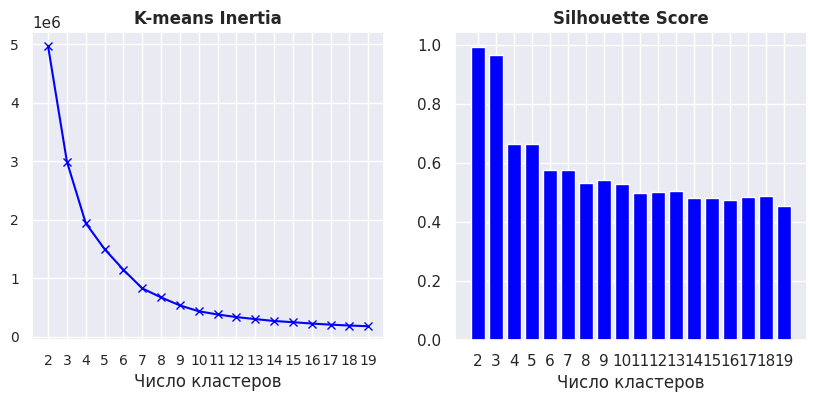

In [17]:
# визуализируем
plot_metrics(inertia, silhouette)

In [18]:
# давайте сделаем кластеризацию с числом кластеров равным 3
kmeans_cv = cluster.KMeans(n_clusters=3,
                        random_state=17,
                        init='k-means++')

kmeans_cv_labels = kmeans_cv.fit_predict(pca_3_result)

display(pd.Series(kmeans_cv_labels).value_counts())

,count
0,22099
2,23
1,1


In [21]:
# ищем центроиды
get_nearest_texts(kmeans_cv, pca_3_result, display=True)

Кластер 0: ближайший текст - The bounty expires in 4 days. Answers to this question are eligible for a +400 reputation bounty. Basj is looking for a canonical answer.I am sending 10 HTTP requests per second between Python Bottle server and a browser client with JS:import bottle, timeapp = bottle.Bottle()@bottle.route('/')def index():    return """<script>var i = 0;setInterval(() => {    i += 1;    let i2 = i;    console.log("sending request", i2);    fetch("/data")        .then((r) => r.text())        .then((arr) => {            console.log("finished processing", i2);        });}, 100);</script>"""@bottle.route('/data')def data():    return "abcd"bottle.run(port=80)The result is rather poor:sending request 1sending request 2sending request 3sending request 4finished processing 1sending request 5sending request 6sending request 7finished processing 2sending request 8sending request 9sending request 10finished processing 3sending request 11sending request 12Why does it fail to process 10

Ну кластеризация у нас сама по себе вышла не самая удачная, ничего не могу сказать про то, описывают ли тексты какие-то кластеры.

In [22]:
# давайте кстати посмотрим, что там у нас в оригинальном датасете по категориям;
# сделаем из строк списки

stckover_df['Categories_lists'] = stckover_df.Categories.apply(ast.literal_eval)
type(stckover_df['Categories_lists'][0])

list

In [23]:
categories = set(chain.from_iterable(stckover_df.Categories_lists))
len(categories)

10634

Так-то категорий достаточно много. Но это я так, из интереса, я не буду делать 10 тысяч кластеров :)

## TF-IDF: K-means

Формула для TF-IDF выглядит следующим образом:

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Введем некоторые понятия: у нас есть отдельные тексты, мы их будем называть документами, и есть корпус, это совокупность документов. Например, для нашей задачи `stckover_df.Question` будет корпусом, а отдельная строка из него - документом.

Базово TF-IDF рассчитывает, насколько важно слово относительно всех слов в нашем корпусе в конкретном документе. Это все, конечно, гениально, но давайте приведем еще формулы конкретно для TF и для IDF:

$$
\text{TF}(t, d) = \frac{n_{t}}{\sum_{k} n_{k}}
$$

TF - Term Frequency, частота какого-то конкретного слова относительно конкретного документа. Рассчитывется как "число вхождений слова поделить на общее количество слов". Тем чаще слово, тем, казалось бы, важнее оно для документа.

...не совсем. Дело в том, что одни и те же слова (речь даже не о служебных) могут встречаться в нескольких документах, и их важность для конкретного нивелируется (мы не можем различить между разными документами по этому слову). И тут на помощь приходит метрика IDF (Inverse Document Frequency):

$$
   \text{IDF}(t, D) = \log\left(\frac{N}{n_t}\right)
$$

Оно показывает, насколько редко слово относительно встречаемости в других документах. Чем оно реже, тем важнее для нашего конкретного документа. Например, если мы встретили слово "Омск" в 2 из 100 документах, при этом частота вхождения слова "Омск" для конкретного документа составляет 0.99, то это очень важное слово для этого документа.

Таким образом, наше изначальное произведение помогает нам учесть оба фактора: частоту слова в конкретном документе и его редкость в корпусе.



In [24]:
# до этого мы работали со словами, которые встретились хотя бы 8 раз;
# сейчас работаем со словами, которые встретились хотя бы в 8 документах
tf_vec = TfidfVectorizer(min_df=8)
embeddings_tfidf = tf_vec.fit_transform(stckover_df.Question)

In [25]:
embeddings_tfidf.shape

(22123, 13512)

In [26]:
# неплохо, но давайте все равно поПСАшим
pca_3_result_tfidf = get_pca_results(embeddings_tfidf, 3)
pca_3_result_tfidf.shape

(22123, 3)

In [27]:
# подбираем

inertia, silhouette = eval_clusters(pca_3_result_tfidf)

100%|██████████| 18/18 [01:51<00:00,  6.18s/it]


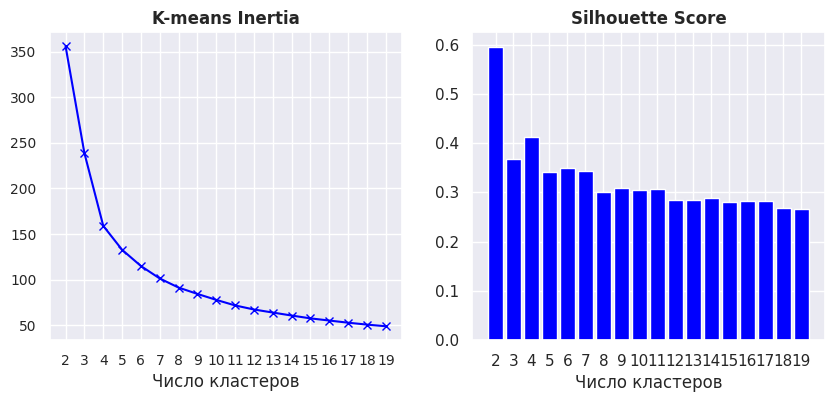

In [28]:
# визуализируем
plot_metrics(inertia, silhouette)

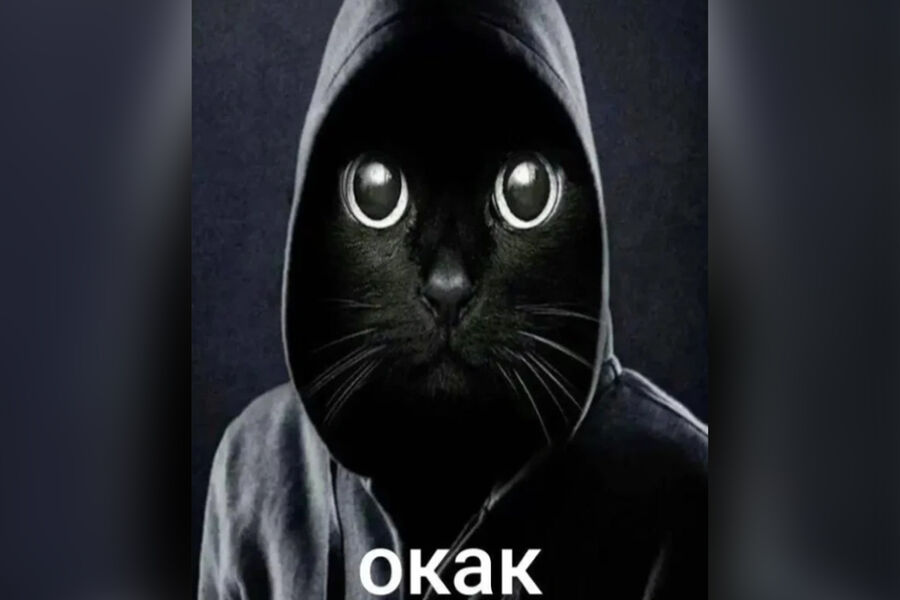

In [29]:
# my honest reaction на значение силуэта
display(Image("https://img.gazeta.ru/files3/374/21045374/okak-pic_32ratio_900x600-900x600-73058.jpg"))

In [30]:
# давайте сделаем кластеризацию с числом кластеров равным 2...
kmeans_tf = cluster.KMeans(n_clusters=2,
                           random_state=17,
                           init='k-means++')

kmeans_tf_labels = kmeans_tf.fit_predict(pca_3_result_tfidf)

display(pd.Series(kmeans_tf_labels).value_counts())

,count
1,14771
0,7352


In [32]:
# ищем центроиды
get_nearest_texts(kmeans_tf, pca_3_result_tfidf, display=True)

Кластер 0: ближайший текст - Closed. This question is opinion-based. It is not currently accepting answers.Want to improve this question? Update the question so it can be answered with facts and citations by editing this post.Closed 5 days ago.Improve this questionHoping someone might be able to help here.I have a group of Ansible Playbook Templates which I am planning to run as part of an Ansible Playbook Workflow.Each of these Ansible Workflow Templates have a survey before them prompting for the fields (as they can be launched independently outside of the Workflow) however, when I go to create them in a Workflow (e.g. a workflow with 5 Playbooks) and have a survey at the launch of the Workflow, I need to set the values of each of the Ansible Playbook Template Surveys that are within the workflow, which override the Workflow Survey's values.Is there an easy way to do this, while retaining the survey within the Workflow Templates outside of a Workflow?I have found that I can untick th

Ну давайте я наугад сделаю предположение, что во втором кластере собрались любители кластеризации (прям как мы...)

## Glove: K-means

In [36]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B

--2025-05-21 12:27:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-21 12:27:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-21 12:27:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [43]:
glove_path = "glove.6B/glove.6B.50d.txt"
glove_vectors = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

glove_vectors["clown"]

array([-0.2688   , -0.51106  , -1.5253   , -0.47003  ,  0.70014  ,
        0.26935  ,  0.65804  , -0.32918  , -0.61481  ,  0.31508  ,
        0.31521  ,  0.30371  ,  0.083439 ,  0.62398  ,  0.55677  ,
       -0.34168  ,  0.095104 ,  1.42     , -0.76932  , -0.70357  ,
       -0.27782  ,  0.4151   , -0.31856  ,  0.54133  , -0.77189  ,
       -0.68601  , -1.2825   ,  0.61394  , -0.0041612, -0.99028  ,
        0.20969  ,  0.58265  ,  0.057365 , -0.25393  , -0.38692  ,
        0.81728  ,  0.60669  , -0.79657  ,  0.23421  , -0.73256  ,
       -0.44275  ,  0.36018  , -0.65617  ,  0.14341  ,  0.73866  ,
       -0.54019  , -0.046248 , -1.6122   ,  0.20361  ,  0.73048  ],
      dtype=float32)

In [52]:
# проверим размерности векторов в модели
glove_vectors.vector_size

50

In [87]:
# чтож, время векторизации
def glove_vectorize(list_of_words):
    vec_list = []
    for word in list_of_words:
        try:
            vec_list.append(glove_vectors[word])
        except KeyError:
            pass

    av_vec = np.mean(vec_list, axis=0)
    return av_vec

In [77]:
# базовая предобработка (без лемматизации и удаления стоп-слов)
# тут все же понадобится; сделаем ее примерно так же, как в прошлый раз
# c CountVectorizer
def base_preproc(string):
    string = string.lower()
    return re.findall(r"(?u)\b\w\w+\b", string)

In [78]:
stckover_df['base_tokenized'] = stckover_df.Question.apply(base_preproc)
stckover_df.head(10)

,Title,URL,Question,Categories,Categories_lists,base_tokenized
0,your browser version is not supported using sy...,https://stackoverflow.com/questions/76981459/y...,I'm trying to automate some features and I nee...,"['php', 'symfony', 'web-scraping']","[php, symfony, web-scraping]","[trying, to, automate, some, features, and, ne..."
1,how to get button text value in java,https://stackoverflow.com/questions/76981456/h...,I want to get button text value to do the on c...,"['java', 'button']","[java, button]","[want, to, get, button, text, value, to, do, t..."
2,How to make sure communication is stable when ...,https://stackoverflow.com/questions/76981455/h...,This is my Node codeasync function runClient()...,"['javascript', 'node.js', 'go', 'zeromq']","[javascript, node.js, go, zeromq]","[this, is, my, node, codeasync, function, runc..."
3,Cubical Agda Inclusion Order,https://stackoverflow.com/questions/76981453/c...,I'm almost finished defining an Inclusion Orde...,['agda'],[agda],"[almost, finished, defining, an, inclusion, or..."
4,How to convert depth map to image(.png) format...,https://stackoverflow.com/questions/76981450/h...,I am using a depth camera which captures a 500...,"['3d', 'computer-vision', 'point-clouds', 'vis...","[3d, computer-vision, point-clouds, vision, op...","[am, using, depth, camera, which, captures, 50..."
5,Spring Security for Mobile Application with 3r...,https://stackoverflow.com/questions/76981449/s...,I want to allow SSO (single sign-on) via Googl...,"['java', 'spring', 'spring-security', 'oauth-2...","[java, spring, spring-security, oauth-2.0]","[want, to, allow, sso, single, sign, on, via, ..."
6,"{C#, UNITY} Currently working on a flight scri...",https://stackoverflow.com/questions/76981448/c...,[EDIT ONE: THE FLIGHT CODE IS COMMENTED BECAUS...,['c#'],[c#],"[edit, one, the, flight, code, is, commented, ..."
7,Overlay a transparent button over each radio o...,https://stackoverflow.com/questions/76981447/o...,I need to overlay a transparent button over ea...,"['javascript', 'html', 'css']","[javascript, html, css]","[need, to, overlay, transparent, button, over,..."
8,Vue list scrolling will affect external scroll...,https://stackoverflow.com/questions/76981446/v...,"By setting the height, the effect of scrolling...","['html', 'vue.js']","[html, vue.js]","[by, setting, the, height, the, effect, of, sc..."
9,How to list all resource to secret mappings?,https://stackoverflow.com/questions/76981442/h...,I am looking for a kubectl command that will l...,"['kubernetes', 'kubectl', 'kubernetes-secrets']","[kubernetes, kubectl, kubernetes-secrets]","[am, looking, for, kubectl, command, that, wil..."


In [79]:
# аккуратно экспериментируем на первом примере
glove_vectorize(stckover_df.base_tokenized[0])

['trying', 'to', 'automate', 'some', 'features', 'and', 'need', 'to', 'scarp', 'web', 'page', 'so', 'using', 'browserkit', 'to', 'make', 'external', 'request', 'to', 'website', 'everything', 'seems', 'good', 'but', 'there', 'no', 'useful', 'result', 'in', 'my', 'response', 'because', 'target', 'page', 'is', 'using', 'modern', 'javascript', 'let', 'take', 'look', 'php', 'filerequire', 'vendor', 'autoload', 'php', 'use', 'symfony', 'component', 'httpclient', 'httpclient', 'client', 'httpclient', 'create', 'max_redirects', 'response', 'client', 'request', 'get', 'https', 'secure', 'konsulat', 'gov', 'pl', 'statuscode', 'response', 'getstatuscode', 'contenttype', 'response', 'getheaders', 'content', 'type', 'content', 'response', 'getcontent', 'dd', 'content', 'dd', 'is', 'installed', 'globally', 'on', 'my', 'php', 'installationand', 'this', 'is', 'content', 'result', 'doctype', 'html', 'html', 'lang', 'en', 'head', 'meta', 'charset', 'utf', 'title', 'system', 'zdalnej', 'rejestracji', 'ti

array([ 2.22542107e-01,  1.44528121e-01,  1.69234216e-01,  7.67039582e-02,
        1.50165424e-01,  7.54922703e-02, -5.30488007e-02, -4.72270697e-01,
       -1.12974562e-01,  1.47391260e-02,  3.68831903e-02,  2.57900387e-01,
       -1.23132663e-02, -3.54486890e-02,  1.49075389e-01,  1.60184473e-01,
       -2.21250951e-01, -1.62291597e-03,  1.22858144e-01, -3.27823609e-01,
       -7.01319128e-02, -1.82033032e-01,  1.34643227e-01,  2.18643755e-01,
        1.39313370e-01, -8.71178389e-01, -3.55543226e-01,  5.80867380e-02,
        2.23147959e-01, -2.30792999e-01,  2.37653017e+00, -9.47884917e-02,
       -2.73314387e-01, -1.85742617e-01, -3.35887931e-02,  1.36849239e-01,
        1.46615654e-01, -4.24286500e-02, -1.29818782e-01, -2.41583914e-01,
        4.07029003e-01, -3.34718227e-02, -4.38787714e-02,  1.99176431e-01,
       -1.32878393e-01,  1.04112089e-01,  2.60055661e-01,  9.21960622e-02,
        1.67477086e-01,  9.81650129e-02], dtype=float32)

In [99]:
# неаккуратно выливаем на оставшийся датасет
glove_vec = list(stckover_df.base_tokenized.apply(glove_vectorize))

In [100]:
# ураа все сточки на месте, а векторы по 50
np.array(glove_vec).shape

(22123, 50)

In [97]:
# я в этот раз даже PCA не буду делать и попробую кластеризовать на всех данных


# Все то же самое для предобработанных текстов



In [ ]:
stop_words = list(set(stopwords.words('english')))

def tokenize(text):

    # нижний регистр
    text = text.lower()
    # исключаем ненужные символы
    text = re.sub(r'[^A-Za-z\s]+', ' ', text)
    # возвращаем список токенов
    return word_tokenize(text)


# напишем функцию для лемматизации: на вход подается список слов, на выходе
# возвращается словарь с формами в ключах и соответствующих им леммами

def get_lemmas_cache(all_words):
    # сделаем все это дело единым списком
    all_words = list(chain.from_iterable(list(all_words)))

    # а теперь лемматизация
    lemmatizer = WordNetLemmatizer()

    cache = dict()
    for word in all_words:
        # чтобы разбирало не только существительные, будем парсить еще часть речи
        pos = pos_tag([word], tagset='universal')[0][1]
        if pos == 'NOUN':
            lemma = lemmatizer.lemmatize(word)
        elif pos == 'VERB':
            lemma = lemmatizer.lemmatize(word, pos='v')
        elif pos == 'ADV':
            lemma = lemmatizer.lemmatize(word, pos='r')
        elif pos == 'ADJ':
            lemma = lemmatizer.lemmatize(word, pos='a')
        else:
            lemma = lemmatizer.lemmatize(word)

        cache[word] = lemma

    return cache

def normalize_text(tokenized_text, lemmas_cache):
    lemmatized = list()
    for word in tokenized_text:
        if word not in stop_words or lemmas_cache[word] not in stop_words:
            lemmatized.append(word)
    return lemmatized

In [ ]:
# проводим токенизацию
stckover_df['tokenized'] = stckover_df.Question.apply(tokenize)

# получаем словарь лемм
stckover_lemmas_cache = get_lemmas_cache(stckover_df.tokenized)

In [ ]:
# получаем нормализованный текст
stckover_df['normalized'] = stckover_df.tokenized.apply(normalize_text,
                                                        lemmas_cache=stckover_lemmas_cache)

In [ ]:
# возвращаем это все дело в строки, потому что cv так работает
stckover_df['str_normalized'] = stckover_df.normalized.apply(lambda x: ' '.join(x))

## CountVectorizer: K-means на предобработанных данных

In [ ]:
count_vec = CountVectorizer(tokenizer=lambda x: x.split(),
                            min_df=8)
embeddings_cv = count_vec.fit_transform(stckover_df.str_normalized)
embeddings_cv.shape

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(22123, 11963)

In [ ]:
pca_3_result_cv_norm = get_pca_results(embeddings_cv, 3)
pca_3_result_cv_norm.shape

(22123, 3)

In [ ]:
inertia, silhouette = eval_clusters(pca_3_result_cv_norm)

100%|██████████| 18/18 [02:05<00:00,  6.99s/it]


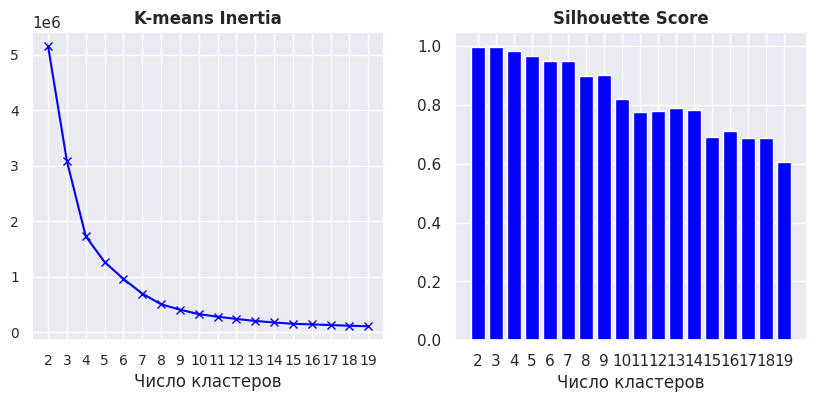

In [ ]:
# визуализируем
plot_metrics(inertia, silhouette)

In [ ]:
# давайте сделаем три кластера
kmeans_cv_norm = cluster.KMeans(n_clusters=3,
                           random_state=17,
                           init='k-means++')

kmeans_cv_norm_labels = kmeans_cv_norm.fit_predict(pca_3_result_cv_norm)

display(pd.Series(kmeans_cv_norm_labels).value_counts())

,count
0,22100
2,22
1,1


Где же ты улучшение... Ну я бы не сказала, все все равно слито в одну кучу

In [ ]:
# ищем центроиды
get_nearest_texts(kmeans_cv_norm, pca_3_result_cv_norm, display=True)

Кластер 0: ближайший текст - I'm trying to modify this code so that the actions button has a little padding that does not highlight on hover below the button.I was trying to use my action-blank class by sandwiching the button between 2 blank lines but the blank lines were getting highlighted.Ideally, the ACTIONS button is present on all sections without needing to click them to appear.vertical-menu {  width: 100%;  height: 150px;  position: relative;}.trend-button:hover {  background: linear-gradient(to right, transparent 2.5%, #f0f0f0 2.5%, #f0f0f0 97.5%, transparent 97.5%);  align-items: center;}/* Exclude blank line and blank element from hover effect */.button-label-line>div:hover,.actions-container>.action-blank {  background: none;}/* Style for the blank element */.action-blank {  height: 0.5em;  /* Adjust height as needed */}.button-label-divider {  height: 5px;}.actions-container>.action-blank {  background: none;}/* Style for the blank element */.action-blank {  height: 0.5em;

## TF-IDF: K-means на предобработанных данных

In [ ]:
tfidf_vec = TfidfVectorizer(tokenizer=lambda x: x.split(),
                            min_df=8)
embeddings_tfidf = tfidf_vec.fit_transform(stckover_df.str_normalized)
embeddings_tfidf.shape

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(22123, 11963)

In [ ]:
pca_3_result_tfidf_norm = get_pca_results(embeddings_cv, 3)
pca_3_result_tfidf_norm.shape

(22123, 3)

In [ ]:
inertia, silhouette = eval_clusters(pca_3_result_tfidf_norm)

100%|██████████| 18/18 [02:14<00:00,  7.46s/it]


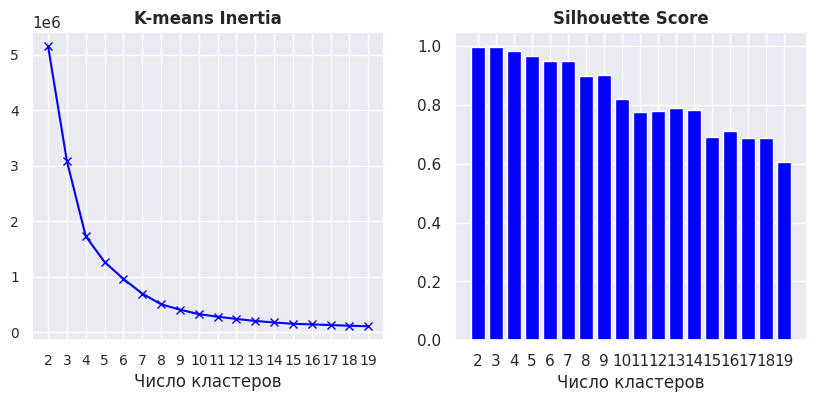

In [ ]:
# визуализируем
plot_metrics(inertia, silhouette)

In [ ]:
# я нас поздравляю, у нас не отрицательный силуэт, улучшение налицо! возьмем 3 кластера
kmeans_tfidf_norm = cluster.KMeans(n_clusters=3,
                           random_state=17,
                           init='k-means++')

kmeans_tfidf_norm_labels = kmeans_tfidf_norm.fit_predict(pca_3_result_tfidf_norm)

display(pd.Series(kmeans_tfidf_norm_labels).value_counts())

,count
0,22100
2,22
1,1


In [ ]:
# богдан все понял, богдана никто не любит, богдан ищет центроиды
get_nearest_texts(kmeans_tfidf_norm, pca_3_result_tfidf_norm, display=True)

Кластер 0: ближайший текст - I'm trying to modify this code so that the actions button has a little padding that does not highlight on hover below the button.I was trying to use my action-blank class by sandwiching the button between 2 blank lines but the blank lines were getting highlighted.Ideally, the ACTIONS button is present on all sections without needing to click them to appear.vertical-menu {  width: 100%;  height: 150px;  position: relative;}.trend-button:hover {  background: linear-gradient(to right, transparent 2.5%, #f0f0f0 2.5%, #f0f0f0 97.5%, transparent 97.5%);  align-items: center;}/* Exclude blank line and blank element from hover effect */.button-label-line>div:hover,.actions-container>.action-blank {  background: none;}/* Style for the blank element */.action-blank {  height: 0.5em;  /* Adjust height as needed */}.button-label-divider {  height: 5px;}.actions-container>.action-blank {  background: none;}/* Style for the blank element */.action-blank {  height: 0.5em;

## Glove: K-means на предобработанных данных

# DBSCAN

# Дополнительные задания